In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import sklearn.linear_model as linear_model
import seaborn as sns
from sklearn.model_selection import KFold
from IPython.display import HTML, display
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit

train = pd.read_csv("4th_week/data/application_train.csv")
test = pd.read_csv("4th_week/data/application_test.csv")

In [3]:
# train.head()

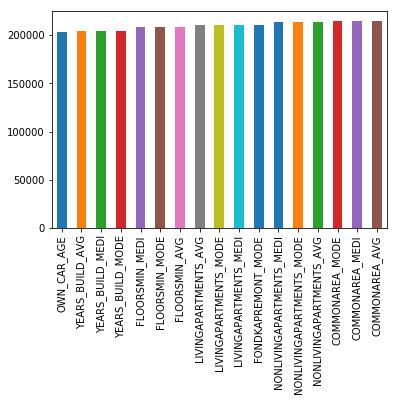

In [4]:
missing = train.isnull().sum()
missing = missing[missing >200000]
missing.sort_values(inplace=True)
missing.plot.bar()

In [5]:
missing

OWN_CAR_AGE                 202929
YEARS_BUILD_AVG             204488
YEARS_BUILD_MEDI            204488
YEARS_BUILD_MODE            204488
FLOORSMIN_MEDI              208642
FLOORSMIN_MODE              208642
FLOORSMIN_AVG               208642
LIVINGAPARTMENTS_AVG        210199
LIVINGAPARTMENTS_MODE       210199
LIVINGAPARTMENTS_MEDI       210199
FONDKAPREMONT_MODE          210295
NONLIVINGAPARTMENTS_MEDI    213514
NONLIVINGAPARTMENTS_MODE    213514
NONLIVINGAPARTMENTS_AVG     213514
COMMONAREA_MODE             214865
COMMONAREA_MEDI             214865
COMMONAREA_AVG              214865
dtype: int64

### 정밀도 : 거짓양성의 수를 줄이는 것이 목표일때 성능지표로 사용, 높은 정밀도가 필요할때<br>
재현율 

In [6]:
train = train.drop(columns=['COMMONAREA_AVG', 'COMMONAREA_MEDI', 'COMMONAREA_MODE', 'NONLIVINGAPARTMENTS_AVG',
                          'NONLIVINGAPARTMENTS_MODE', 'NONLIVINGAPARTMENTS_MEDI'])
numerical = [f for f in train.columns if train.dtypes[f] != 'object']
numerical.remove('TARGET')
categorical = [f for f in train.columns if train.dtypes[f] == 'object']


In [7]:
# f = pd.melt(train, value_vars=numerical)
# g = sns.FacetGrid(f, col="variable",  col_wrap=2, sharex=False, sharey=False)
# g = g.map(sns.distplot, "value")

In [8]:
for c in categorical:
    train[c] = train[c].astype('category')
    if train[c].isnull().any():
        train[c] = train[c].cat.add_categories(['MISSING'])
        train[c] = train[c].fillna('MISSING')

In [9]:
# def boxplot(x, y, **kwargs):
#     sns.boxplot(x=x, y=y)
#     x=plt.xticks(rotation=90)
# f = pd.melt(train, id_vars=['TARGET'], value_vars=categorical)
# g = sns.FacetGrid(f, col="variable",  col_wrap=2, sharex=False, sharey=False, size=5)
# g = g.map(boxplot, "value", "TARGET")

In [10]:
def encode(frame, feature):
    ordering = pd.DataFrame()
    ordering['val'] = frame[feature].unique()
    ordering.index = ordering.val
    # ordering['spmean'] = frame[[feature, 'TARGET']].groupby(feature).mean()['TARGET']
    # ordering = ordering.sort_values('spmean')
    ordering['ordering'] = range(1, ordering.shape[0]+1)
    ordering = ordering['ordering'].to_dict()

    for cat, o in ordering.items():
        frame.loc[frame[feature] == cat, feature+'_E'] = o

cate_encoded = []
for q in categorical:
    encode(train, q)
    cate_encoded.append(q+'_E')
# print(cate_encoded)

In [11]:
def spearman(frame, features):
    spr = pd.DataFrame()
    spr['feature'] = features
    spr['spearman'] = [frame[f].corr(frame['TARGET'], 'spearman') for f in features]
    spr = spr.sort_values('spearman')
    plt.figure(figsize=(6, 0.25*len(features)))
    sns.barplot(data=spr, y='feature', x='spearman', orient='h')

features = numerical + cate_encoded
# spearman(train, features)

In [12]:
def pairplot(x, y, **kwargs):
    ax = plt.gca()
    ts = pd.DataFrame({'time': x, 'val': y})
    ts = ts.groupby('time').mean()
    ts.plot(ax=ax)
    plt.xticks(rotation=90)

# f = pd.melt(train, id_vars=['TARGET'], value_vars=numerical+cate_encoded)
# g = sns.FacetGrid(f, col="variable",  col_wrap=2, sharex=False, sharey=False, size=5)
# g = g.map(pairplot, "value", "TARGET")

In [13]:
def error(actual, predicted):
    actual = np.log(actual)
    predicted = np.log(predicted)
    return np.sqrt(np.sum(np.square(actual-predicted))/len(actual))

def log_transform(feature):
    train[feature] = np.log1p(train[feature].values)

def quadratic(feature):
    train[feature+'2'] = train[feature]**2

In [14]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=42)
for train_index, test_index in split.split(train, train["NAME_INCOME_TYPE"]):
    train_set = train.loc[train_index]
    test_set = train.loc[test_index]

In [15]:
features = numerical + cate_encoded
X_train = train_set[features].fillna(0.).values
X_test = test_set[features].fillna(0.).values
y_train = train_set['TARGET'].values
y_test = test_set['TARGET'].values

### 정밀도 : 거짓양성의 수를 줄이는 것이 목표일때 성능지표로 사용, 높은 정밀도가 필요할때<br>

In [16]:
from sklearn.svm import SVC
from sklearn.metrics import roc_curve

svc = SVC(gamma=.05).fit(X_train, y_train)

fpr, tpr, thresholds = roc_curve(y_test, svc.decision_function(X_test))
plt.plot(fpr, tpr, label="ROC Curve")
plt.xlabel("FPR")
plt.ylabel("TPR(재현율)")

close_zero = np.argmin(np.abs(thresholds))
plt.plot(fpr[close_zero], tpr[close_zero], 'o', markersize=10, label="임계값", fillstyle="none", c='k', mew=2)
plt.legend(loc=4)


In [19]:
# from sklearn.ensemble import RandomForestClassifier
# 
# rf = RandomForestClassifier(n_estimators=100, random_state=0, max_features=2)
# 
# fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test, rf.predict_proba(X_test)[:, 1])
# 
# plt.plot(fpr, tpr, label="SVC ROC Curve")
# plt.plot(fpr_rf, tpr_rf, label="RF ROC Curve")
# 
# plt.xlabel("FPR")
# plt.ylabel("TPR(재현율)")
# plt.plot(fpr[close_zero], tpr[close_zero], 'o', markersize=10, label="SVC 임계값 0", fillstyle="none", c='k', mew=2)
# close_default_rf = np.argmin(np.abs(thresholds_rf - 0.5))
# 
# plt.legend(loc=4)

In [16]:
# test.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100001,Cash loans,F,N,Y,0,135000.0,568800.0,20560.5,450000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
1,100005,Cash loans,M,N,Y,0,99000.0,222768.0,17370.0,180000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
2,100013,Cash loans,M,Y,Y,0,202500.0,663264.0,69777.0,630000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,4.0
3,100028,Cash loans,F,N,Y,2,315000.0,1575000.0,49018.5,1575000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
4,100038,Cash loans,M,Y,N,1,180000.0,625500.0,32067.0,625500.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


In [17]:
# 테스트 데이터 가공

# test = test.drop(columns=['COMMONAREA_AVG', 'COMMONAREA_MEDI', 'COMMONAREA_MODE', 'NONLIVINGAPARTMENTS_AVG',
#                           'NONLIVINGAPARTMENTS_MODE', 'NONLIVINGAPARTMENTS_MEDI'])
# numerical_t = [f for f in test.columns if test.dtypes[f] != 'object']
# categorical_t = [f for f in test.columns if test.dtypes[f] == 'object']
# 
# for c in categorical_t:
#     test[c] = test[c].astype('category')
#     if test[c].isnull().any():
#         test[c] = test[c].cat.add_categories(['MISSING'])
#         test[c] = test[c].fillna('MISSING')
# 
# cate_encoded = []
# for q in categorical_t:
#     encode(test, q)
#     cate_encoded.append(q+'_E')
# 
# features = numerical_t + cate_encoded
# X_test = test[features].fillna(0.).values